(parameters_recovery)=
# Parameters recovery, prior predictive and posterior predictive sampling

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/4-Parameter_recovery.ipynb)

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    !pip install pyhgf

In [2]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from numpy import loadtxt

from pyhgf import load_data
from pyhgf.distribution import HGFDistribution, hgf_logp

In [3]:
np.random.seed(123)

In this tutorial, we are going to demonstrate some forms of parameters recovery, prior predictive and posterior predictive sampling that can be a way to assess the strength of the model fitting.

## Continuous HGF
### Simulate a dataset

In [4]:
n_data = 6
dataset = []
for participant in range(n_data):
    input_data = []
    kappa_1 = 1.0
    omega_1 = -10.0
    omega_2 = -10.0
    mu_1 = 0.0
    mu_2 = 0.0
    pi_1 = 1e4
    pi_2 = 1e1
    
    # two-level hierarchical gaussian random walk
    for i in range(1000):
        
        # x2
        pi_2 = np.exp(omega_2)
        mu_2 = np.random.normal(mu_2, pi_2**.5)

        # x1
        pi_1 = np.exp(kappa_1 * mu_2 + omega_1)
        mu_1 = np.random.normal(mu_1, pi_1**.5)
        
        # input node
        u = np.random.normal(mu_1, 1e-4**.5)
        input_data.append(u)

    dataset.append(np.array(input_data))

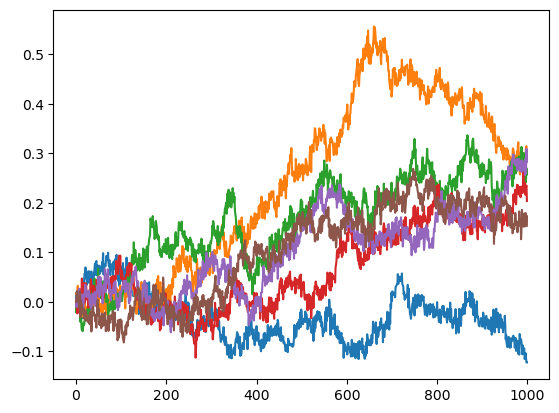

In [5]:
for rw in dataset:
    plt.plot(rw)

## Embedding a serie of HGFs in a graphical model

Here, we are goingin to estimate the parameter $omega_{1}$ from the time series created by the hierarchical random walks. All the time series were generated using $omega_{1} = -10.0$ and we want to see how the Bayesian inference can retrieve these values.

In [6]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="continuous",
    input_data=dataset,
)

In [7]:
with pm.Model() as model:
    
    # Priors
    # ------
    tonic_volatility_1 = pm.Normal("omega_1", mu=0.0, sigma=2.0, shape=n_data)

    # The multi-HGF distribution
    # --------------------------
    pm.Potential("hgf_loglike", hgf_logp_op(tonic_volatility_1=tonic_volatility_1, tonic_volatility_2=-10.0))

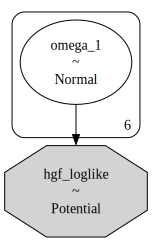

In [8]:
pm.model_to_graphviz(model)

In [9]:
with model:
    idata = pm.sample(chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
I0000 00:00:1701371409.912166   24411 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [omega_1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 74 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


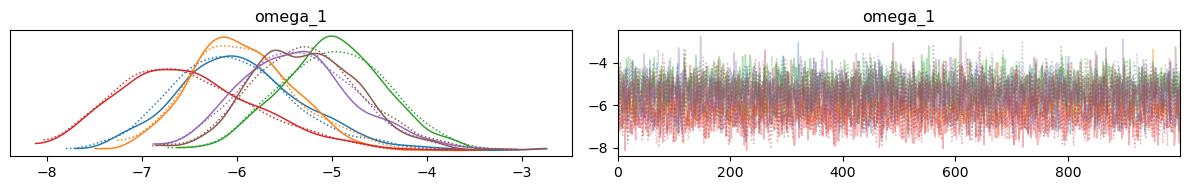

In [10]:
az.plot_trace(idata);
plt.tight_layout()

In [11]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega_1[0],-5.995,0.660,-7.278,-4.790,0.015,0.010,2172.0,1260.0,1.0
omega_1[1],-5.943,0.545,-7.007,-4.975,0.013,0.009,1832.0,1336.0,1.0
omega_1[2],-4.979,0.558,-6.054,-3.992,0.013,0.009,1958.0,1727.0,1.0
omega_1[3],-6.508,0.744,-7.790,-5.133,0.017,0.012,2046.0,1464.0,1.0
omega_1[4],-5.351,0.612,-6.422,-4.162,0.013,0.009,2272.0,1614.0,1.0
omega_1[5],-5.260,0.583,-6.309,-4.160,0.013,0.009,2139.0,1371.0,1.0


# System configuration

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Thu Nov 30 2023

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

pyhgf : 0.0.12
jax   : 0.4.16
jaxlib: 0.4.16

numpy     : 1.22.0
pymc      : 5.9.1
matplotlib: 3.7.1
sys       : 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
jax       : 0.4.16
arviz     : 0.16.1

Watermark: 2.4.3

